In [2]:
import torch
import numpy as np

# Introduccion a Pytorch

Pytorch es una libreria que permite trabajar con vectores y matrices de muchas dimensiones.

En ese sentido es muy parecido a Numpy. En numpy a los vectores son llamados arrays. En pytorch se los llama tensores.

In [3]:
a = torch.tensor([[1.,2.],[3.,4.]])
a

tensor([[1., 2.],
        [3., 4.]])

In [4]:
a.shape

torch.Size([2, 2])

El shape del tensor es una lista del tamano de cada dimension. Si trabajamos con matrices (como comumnmente se llama a los vectores 2D), cada "fila" tiene la misma longitud: no hay una fila mas corta que otra.

Lo mismo vale para mas dimensiones. No podemos hacer:

In [5]:
torch.tensor([[1.,2.],[3.]])

ValueError: expected sequence of length 2 at dim 1 (got 1)

## Que introduce de nuevo pytorch sobre numpy
Esencialmente dos cosas:
- Paralelizacion en GPU
- Calculo automatico de derivadas (gradiente)

Estas funciones son muy deseables cuando trabajamos con redes neuronales. Aunque tambien hay librerias de, por ejemplo, algebra lineal que han aprovechado esto para ser escritas sobre pytorch y funcionar eficientemente.

Pytorch tambien provee muchas de las funcionalidades necesarias para definir una red y entrenarla.

Con la siguiente funcion podemos ver si tenemos una GPU disponible en nuestro sistema

In [123]:
torch.cuda.is_available()

False

Podemos comparar la velocidad entre ejecutar algo en CPU o usando GPU (si tenemos).

Pytorch requiere mover explicitamente los tensores a la GPU, se puede hacer facilmente mediante el metodo .cuda()

(Si se operan vectores que estan en la GPU con vectores que estan en la GPU causara un error)

In [124]:
%%timeit
A = torch.rand(1000,1000)
B = torch.rand(1000,1000)
A@B

85.2 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
%%timeit
if torch.cuda.is_available():
    A = A.cuda()
    B = B.cuda()
    A@B

636 ns ± 3.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### Ejercicio Opcional 1

Ejecutar el codigo anterior en una GPU. Para ello se pueden utilizar las GPU de papparspace u otro proveedor cloud.

## Pytorch Autograd

Pytorch provee la funcionalidad "recordar" como cada vector fue calculado con el fin de computar el gradiente.

Podemos definir vectores con ciertos valores y crear otros como resultado de operar los primeros y pytorch recordara el grafo de las computaciones.

Supongamos que tenemos los vectores:

$ a = 1 $

$ b = 2 $

$ c = 0 $

Y definimos $m$, $n$ (capas intermedias), $p$ (una prediccion) y $l$ (un costo) como:

$ m = a + b $

$ n = max(b,c) $

$ p = m \times n $

$ l = p^2 $

Pytorch calculara los valores intermedios dado el valor de las hojas:

$ m = 3 $

$ n = 2 $

$ p = 6 $

$ l = 36 $

Y a la vez construira el siguiente grafo de computaciones:

![title](graph.png)

Si $a$,$b$,$c$ son nuestros parametros y queremos minimizar el costo $l$. Querremos calcular: $\large\frac{\partial l}{\partial a}$, $\large\frac{\partial l}{\partial b}$, $\large\frac{\partial l}{\partial c}$

A primera vista no es fácil calcular dichas derivadas. En general, usando la definición de los valores, podemos calcular la derivada de un valor en función de los valores que dependen de forma directa de él. Haciendo referencia al grafo de las computaciones (la imagen de arriba), podemos calcular el valor de $\large\frac{\partial y}{\partial x}$ si existe una arista que $x \rightarrow y$. Así, podemos calcular las siguientes derivadas, ya que cada variable depende de forma directa una de la otra:

$\large\frac{\partial l}{\partial p} = 2 \times p = 12$

$\large\frac{\partial p}{\partial m} = n = 2$

$\large\frac{\partial p}{\partial n} = m = 3$

$\large\frac{\partial m}{\partial a} = 1$

$\large \frac{\partial m}{\partial b} = 1$

$\large \frac{\partial n}{\partial b} = 1$

$\large \frac{\partial n}{\partial c} = 0$

Pero como hacemos para calcular las derivadas $\large\frac{\partial l}{\partial a}$, $\large\frac{\partial l}{\partial b}$, $\large\frac{\partial l}{\partial c}$ que son las que necesitamos para actualizar el gradiente? 

Centrémosnos por un momento en el caso de $\large\frac{\partial l}{\partial a}$. Si bien no tenemos una fórmula que relacione de manera directa $a$ con $l$, el valor de $l$ depende del valor de $a$: esto es debido a que el valor de $l$ depende de $p$, que a su vez depende de $m$, que por último depende de $a$.

Apliquemos la regla de la cadena entre $p$ (que es una función de $a$), $l$ (que es función de $p$) y $a$:

$\Large\frac{\partial l}{\partial m} = \frac{\partial l}{\partial p} \times \frac{\partial p}{\partial m}$

La regla de la cadena es un t

Usando las definicion de cada valor y la regla de la cadena tenemos que:





$\large\frac{\partial l}{\partial m} = \frac{\partial l}{\partial p} \times \frac{\partial p}{\partial m} = 12 \times 2 = 24$



$\large\frac{\partial l}{\partial n} = \frac{\partial l}{\partial p} \times \frac{\partial p}{\partial n} = 12 \times 3 = 36$



$\large\frac{\partial l}{\partial a} = \frac{\partial l}{\partial m} \times \frac{\partial m}{\partial a} = 24 \times 1 = 24$





Para el caso de $b$ usamos la red de la cadena multivariada (es muy parecida a la regla del producto, de hecho la regla del producto es un caso particular de la regla de la cadena multivariada):

$\large\frac{\partial l}{\partial b} = \frac{\partial l}{\partial m} \times \frac{\partial m}{\partial b} + \frac{\partial l}{\partial n} \times \frac{\partial n}{\partial b} = 24+36 = 60$

In [8]:
a = torch.tensor([1.],requires_grad=True)
b = torch.tensor([2.],requires_grad=True)
c = torch.tensor([0.],requires_grad=True)
a,b,c

(tensor([1.], requires_grad=True),
 tensor([2.], requires_grad=True),
 tensor([0.], requires_grad=True))

In [126]:
m = a+b
n = torch.max(a,b)
m, n

(tensor([3.], grad_fn=<AddBackward0>),
 tensor([2.], grad_fn=<MaximumBackward0>))

In [127]:
p = m*n
l = p**2
p, l

(tensor([6.], grad_fn=<MulBackward0>), tensor([36.], grad_fn=<PowBackward0>))

In [128]:
m.retain_grad()
n.retain_grad()
p.retain_grad()
l.retain_grad()

l.backward()

In [130]:
l.grad, p.grad

(tensor([1.]), tensor([12.]))

In [129]:
m.grad, n.grad

(tensor([24.]), tensor([36.]))

In [131]:
a.grad, b.grad, c.grad

(tensor([24.]), tensor([60.]), None)

### Interpretación del gradiente

Recordar que el gradiente $\large \frac{\partial l}{\partial a}$ indica cuánto cambia $l$ ante pequeños cambios de $a$:

$\large \frac{\partial l}{\partial a} = lim_{\Delta a \rightarrow 0} \frac{\Delta l}{\Delta a}$

Corroboraremos esto empíricamente, calculando $\Delta l$ para variaciones $\Delta a$, $\Delta b$, $\Delta c$ muy pequeñas.

Para ellos haremos una función que nos calcule $l$ dado $a$, $b$ y $c$c

In [9]:
def calculate_l(a,b,c):
    m = a+b
    n = torch.max(a,b)
    p = m*n
    l = p**2
    return l

Chequeamos que el resultado es efectivamente 36:

In [11]:
ov = calculate_l(a, b, c)
ov

tensor([36.], grad_fn=<PowBackward0>)

Luego calcularemos $l$ introduciendo un pequeño cambio en $a$. Observaremos como resulta el ratio de cambio $\frac{\Delta l}{\Delta a}$

In [26]:
small_change = 0.001
nv = calculate_l(a + small_change, b, c)
print(f'New value: {(nv).item()}')
print(f'Change value: {(nv - ov).item()}')
print(f'Change ration: {((nv - ov) / small_change).item()}')

New value: 36.02400207519531
Change value: 0.0240020751953125
Change ration: 24.002073287963867


Efectivamente el ratio de variación es 24, como la derivada $\large \frac{\partial l}{\partial a}$.
Haremos lo mismo para $b$ y para $c$:

In [27]:
nv = calculate_l(a , b + small_change, c)
nv, (nv - ov) / small_change
print(f'New value: {(nv).item()}')
print(f'Change value: {(nv - ov).item()}')
print(f'Change ration: {((nv - ov) / small_change).item()}')

New value: 36.06003189086914
Change value: 0.060031890869140625
Change ration: 60.03188705444336


In [28]:
nv = calculate_l(a , b, c + small_change)
nv, (nv - ov) / small_change
print(f'New value: {(nv).item()}')
print(f'Change value: {(nv - ov).item()}')
print(f'Change ration: {((nv - ov) / small_change).item()}')

New value: 36.0
Change value: 0.0
Change ration: 0.0


#### Ejercicio Opcional 2

Dada las siguientes definiciones:

$a = 2$

$b = 3$

$c = -1$

$d = 7$

$m = 3 \times a + 4 \times b - 2 \times c + 10 \times d$

$n = 7 \times a + b + \times c + 4 \times d$

$p = max(m,0)$

$q = max(n,0)$

$z = p - q$

$ pred = \frac{1}{1 + e^{-x}}$

$loss = log(pred)$

Calcular:

1. El grafo de las computaciones (un diagrama de flechas como el de arriba donde se vea la relación de dependencia entre las variables).
2. Las derivadas $\large \frac{\partial loss}{\partial a}$, $\large \frac{\partial loss}{\partial b}$, $\large \frac{\partial loss}{\partial c}$, $\large \frac{\partial loss}{\partial d}$ manualmente.
3. Las derivadas $\large \frac{\partial loss}{\partial a}$, $\large \frac{\partial loss}{\partial b}$, $\large \frac{\partial loss}{\partial c}$, $\large \frac{\partial loss}{\partial d}$ utilizando Pytorch Autograd (backwards).
4. Una aproximación de las derivadas $\large \frac{\partial loss}{\partial a}$, $\large \frac{\partial loss}{\partial b}$, $\large \frac{\partial loss}{\partial c}$, $\large \frac{\partial loss}{\partial d}$ mediante los ratios $\large \frac{\Delta loss}{\Delta a}$, $\large \frac{\Delta loss}{\Delta b}$, $\large \frac{\Delta loss}{\Delta c}$, $\large \frac{\Delta loss}{\Delta d}$ de cambio utilizando pequeñas variaciones $\Delta a$, $\Delta b$, $\Delta c$, $\Delta d$.

## Utilizando descenso por gradiente para problemas de optimización

El método de descenso por gradiente permite optimizar (maximizar o minimizar) cualquier función $f(w)$. Consiste comenzar en cualquier $w_0$ aleatorio y hacer iterativamente (una y otra vez) la siguiente actualización:

$w_{t+1} = w_{t} - \eta \times f'(w_t)$

Por ejemplo si queremos hallar el mínimo de la siguiente función cuadrática:

$f(x) = (x-3)^2 + 10$

Podemos hacerlo analíticamente: observar que es una parábola con vértice en $x=3$ y que este es el $x$ que arrojará valores mínimos. Particularmente:

$f(3) = 10$


Pero también podemos calcular el mínimo con el método de descenso por gradiente:

In [35]:
def f(x):
    return (x-3)**2+10

In [53]:
w = torch.rand(1, requires_grad=True)
w

tensor([0.2463], requires_grad=True)

La siguiente celda ejecuta un paso de descenso por gradiente. Si la ejecutamos sucesivas veces se puede observar que el valor de $f$ se reduce:

In [54]:
def iteration_gradient_descent(learning_rate = 0.01, show_value=False):
    value = f(w)
    if show_value:
        print(f'f({w.item()}) = {value.item()}')
    value.backward()
    w.data = w.data - learning_rate * w.grad
    w.grad.zero_()

iteration_gradient_descent(show_value=True)

f(0.24625301361083984) = 17.58312225341797


Ejecutando dentro de un loop para hacer muchas iteraciones:

In [55]:
for iteration_number in range(1000):
    iteration_gradient_descent(show_value = (iteration_number%100 == 0))

f(0.3013279438018799) = 17.2828311920166
f(2.6421031951904297) = 10.128089904785156
f(2.952536106109619) = 10.002252578735352
f(2.9937055110931396) = 10.000040054321289
f(2.999164581298828) = 10.000000953674316
f(2.9998891353607178) = 10.0
f(2.9999847412109375) = 10.0
f(2.9999942779541016) = 10.0
f(2.9999942779541016) = 10.0
f(2.9999942779541016) = 10.0


Finalmente hemos encontrado el valor de $x$ que minimiza $f(x)$

In [57]:
f(w.data), w.data

(tensor([10.]), tensor([3.0000]))

### Otra aplicación de descenso por gradiente

Vimos que descenso por gradiente sirve para encontrar el mínimo de funciones. Pero también es útil en problemas que queremos encontrar cierta incógnita. Veremos cómo se puede hallar la inversa de una matriz con descenso por gradiente.

Recordar que si tenemos una matriz $A$:
\begin{bmatrix}
    1 & 2 & 3 \\
    0 & 1 & 4 \\
    5 & 6 & 0
\end{bmatrix}
Su inversa $A^{-1}$ es:
\begin{bmatrix}
    -24 & 18 & 5 \\
    20 & -15 & -4 \\
    -5 & 4 & 1
\end{bmatrix}
Debido a que el [producto](https://en.wikipedia.org/wiki/Matrix_multiplication) de ambas es la identidad $A \times A^{-1} = I$. 

Recordar que la identidad $I$ es:
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1
\end{bmatrix}

In [301]:
values = [[1,2,3],
          [0,1,4],
          [5,6,0]]
A = torch.tensor(values, dtype=torch.float)
A

tensor([[1., 2., 3.],
        [0., 1., 4.],
        [5., 6., 0.]])

Existen métodos para calcular la inversa de una matrix. Pytorch ya posee dicha funcionalidad como una función de librería:

In [68]:
A_inversed = torch.inverse(A)
A_inversed

tensor([[-24.0000,  18.0000,   5.0000],
        [ 20.0000, -15.0000,  -4.0000],
        [ -5.0000,   4.0000,   1.0000]])

Pytorch posee además métodos para definir matrices útiles como la identidad:

In [69]:
torch.eye(A.shape[0])

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Podemos corroborar que el producto de la inversa calculada por la matriz original es la identidad. Si se mira con atención en la diagonal hay todos $1$ y en las entradas que no pertenecen a la diagonal hay números muy pequeños (casi 0). Esto es producto a [errores numéricos](https://en.wikipedia.org/wiki/Numerical_error), (recordar que la representación como float no es exacta)

In [70]:
A_inversed @ A

tensor([[ 1.0000e+00,  3.8147e-06,  0.0000e+00],
        [ 0.0000e+00,  1.0000e+00, -3.8147e-06],
        [ 4.7684e-07,  1.9073e-06,  1.0000e+00]])

Pero cómo usamos descenso por gradiente para encontrar $A^{-1}$? No sirve sólo para problemas de minimización?

$A_{-1}$ es la única matriz que multiplicada por $A$ da la identidad:

$A \times A_{-1} = I$

Lo que es equivalente a decir:

$A \times A_{-1} - I = 0$

Y a su vez, es equivalente a:

$||A \times A_{-1} - I ||_2 = 0$

La norma $|| . ||_2$ es siempre positiva (o cero). Por lo cual, encontrar $A_{-1}$ es equivalente a minimizar:

$f(W) = ||A \times W - I ||_2 $

Comenzaremos con una matriz $W_0$ aleatoria e iremos actualizando sus entradas con descenso por gradiente para minimizar $f$ definida tal como se muestra arriba.

In [71]:
def f(W):
    dim = A.shape[0]
    I = torch.eye(dim)
    return torch.norm(A @ W - I)

Nuestro $W$ inicial está lejos de ser la inversa $A_{-1}$ buscada:

In [92]:
W = torch.rand((3,3), requires_grad=True)
W

tensor([[0.7539, 0.6806, 0.3723],
        [0.7387, 0.1340, 0.2240],
        [0.3931, 0.3627, 0.0761]], requires_grad=True)

$f(W)$ que puede ser interpretado como "el error" de nuestra solución está lejos de ser $0$:

In [93]:
f(W)

tensor(10.3368, grad_fn=<LinalgVectorNormBackward0>)

La función que realiza una iteración de descenso por gradiente es igual que la que usamos para nuestra función cuadrática.
También podemos corrobarar, una vez más que ejecutando sucesivas iteraciones el valor de $f$ es cada vez menor:

In [83]:
def iteration_gradient_descent(learning_rate = 0.01, show_value=False):
    value = f(W)
    if show_value:
        print(f'f(W) = {value.item()}')
        print(W)
    value.backward()
    W.data = W.data - learning_rate * W.grad
    W.grad.zero_()

iteration_gradient_descent(show_value=True)

f(W) = 0.9843394160270691
tensor([[-0.1036,  0.5337,  0.5128],
        [ 0.1075, -0.4602, -0.2646],
        [ 0.0896,  0.2799,  0.0443]], requires_grad=True)


Para hacer varias iteraciones utilizaremos learning rates cada vez más chicos (recordar que al aproximarse al mínimo es conveniente reducir el learning rate para no "saltar" por encima del mínimo):

In [94]:
for lr_exponent in range(1,7):
    n_iter_to_show = 100000
    n_iter = n_iter_to_show * 3
    learning_rate = 0.1 ** lr_exponent
    for iteration_number in range(n_iter):
        iteration_gradient_descent(show_value = (iteration_number%n_iter_to_show == 0), learning_rate = learning_rate)

f(W) = 10.336766242980957
tensor([[0.7539, 0.6806, 0.3723],
        [0.7387, 0.1340, 0.2240],
        [0.3931, 0.3627, 0.0761]], requires_grad=True)
f(W) = 3.426985025405884
tensor([[-20.2819,  15.0119,   4.1587],
        [ 16.4554, -12.7515,  -3.4269],
        [ -4.2405,   3.3464,   0.8116]], requires_grad=True)
f(W) = 3.4278721809387207
tensor([[-23.5711,  17.4188,   4.8127],
        [ 19.1932, -14.7557,  -3.9718],
        [ -4.9411,   3.8590,   0.9509]], requires_grad=True)
f(W) = 3.4236056804656982
tensor([[-24.1061,  17.8119,   4.9193],
        [ 19.6390, -15.0825,  -4.0604],
        [ -5.0550,   3.9427,   0.9736]], requires_grad=True)
f(W) = 0.3344844877719879
tensor([[-23.9776,  17.9600,   4.9859],
        [ 19.9374, -14.9900,  -4.0007],
        [ -4.9984,   3.9898,   0.9961]], requires_grad=True)
f(W) = 0.3344844877719879
tensor([[-23.9776,  17.9600,   4.9859],
        [ 19.9374, -14.9900,  -4.0007],
        [ -4.9984,   3.9898,   0.9961]], requires_grad=True)
f(W) = 0.33448448

El $W$ obtenido es una aproximacion relativamente buena de $A^{-1}$

In [95]:
W

tensor([[-23.9635,  17.9751,   4.9929],
        [ 19.9696, -14.9793,  -3.9941],
        [ -4.9922,   3.9947,   0.9985]], requires_grad=True)

In [97]:
A_inversed

tensor([[-24.0000,  18.0000,   5.0000],
        [ 20.0000, -15.0000,  -4.0000],
        [ -5.0000,   4.0000,   1.0000]])

#### Ejercicio Opcional 3

Utilizar el método de descenso por gradiente para resolver el siguiente sistema de ecuaciones:

$ 3 x + 4 y - 2 z = 0$

$ 2 x - 3 y + 4 z = 11$

$ x - 2 y + 3 z = 7$

Hint: recordar la representación matricial del sistema de ecuaciones.

In [118]:
from torchvision import datasets, transforms

batch_size = 32
train_kwargs = {'batch_size': 32}
test_kwargs = {'batch_size': 32}


transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [119]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [123]:

loss_fn = nn.CrossEntropyLoss()

In [124]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [108]:


for i_epoc in range(n_epoch):
    

SyntaxError: incomplete input (3145931182.py, line 2)

In [187]:
for x,y in train_loader:
    break
x.shape

torch.Size([32, 1, 28, 28])

In [194]:
x.reshape(32,-1).shape

torch.Size([32, 784])

In [191]:
x[0].shapea

torch.Size([1, 28, 28])

In [190]:
dataset1[3000][1]

9

In [177]:
dataset1[3000][0].shape

torch.Size([1, 28, 28])

In [182]:
tensor_image = dataset1[3000][0]

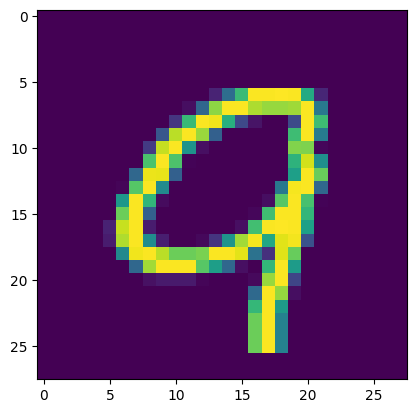

In [183]:
import matplotlib.pyplot as plt

plt.imshow(  tensor_image.permute(1, 2, 0)  )


In [ ]:
# Mueble: 0
# Repuesto: 1
# Herramienta: 2

# Mueble: [1,0,0]
# Repuesto: [0,1,0]
# Herramienta: [0,0,1]

In [ ]:
# Texto : R^size(diccionario)
# Texto[i] = cant de veces que aparece la palabra i-esima

In [ ]:
# Word : R^size(diccionario)
# Word[i] = 1 si y solo si la palabra en cuestion esta en la posicion i-esima
# "perro" si esta en la posicion 20 [0,0,0 ... , 1 , 0, 0, ... 0]

In [ ]:
texto = si queremos meter texto en una _ neuronal necesitamos representarlo como un vector

texto[i]: la palabra en la posicion i-esima
    
vector[i] = el vector de la palabra texto[i]